# Smart Restaurant Multi-Agent System (SRMAS)
**Author:** Thati Manasa (github: manut03)

**Project:** Agents Intensive - Capstone Project (Concierge / Enterprise hybrid)  
**Notebook version:** Initial Multi-Agent System Build

**Short description:** SRMAS is an offline-capable, multi-agent assistant for small restaurants. It demonstrates multi-agent coordination (billing agent, inventory agent, analytics agent), session & memory management, and simple tool integration (inventory adjustments, bill generation, reports).

---

## Table of contents
1. Setup & dependencies
2. Data (synthetic menu & inventory)
3. Agent definitions & runner (simulated agent flows)
4. Place orders / Billing demo
5. Inventory updates & memory bank
6. Analytics and reporting (top items, daily summary)
7. Conclusions & next steps
8. Synthetic Sales + Rich Analytics

**Setup & dependencies (header + install)**

In [ ]:
!pip install -q pandas numpy matplotlib rich

import matplotlib.pyplot as plt  # ← missing import

plt.style.use('ggplot')
print("Cell 1: deps OK")


**Synthetic menu & inventory creation**

In [ ]:
# Create synthetic menu & inventory (saved under ./data)
# Imports and synthetic dataset files
import os, uuid, asyncio, datetime, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich import print as rprint
from pprint import pprint

# Create a reproducible synthetic menu + inventory CSVs
menu = [
    {"item_id":"M001","name":"Idly","category":"Breakfast","price":30,"unit":"plate"},
    {"item_id":"M002","name":"Dosa","category":"Breakfast","price":50,"unit":"plate"},
    {"item_id":"M003","name":"Fried Rice","category":"Main","price":120,"unit":"plate"},
    {"item_id":"M004","name":"Paneer Curry","category":"Main","price":180,"unit":"plate"},
    {"item_id":"M005","name":"Coke","category":"Beverage","price":40,"unit":"bottle"},
    {"item_id":"M006","name":"Coffee","category":"Beverage","price":35,"unit":"cup"}
]

inventory = [
    {"item_id":"I001","name":"Rice (kg)","qty":20,"unit":"kg"},
    {"item_id":"I002","name":"Paneer (kg)","qty":5,"unit":"kg"},
    {"item_id":"I003","name":"Vegetables (kg)","qty":30,"unit":"kg"},
    {"item_id":"I004","name":"Coke Bottles","qty":50,"unit":"pcs"},
    {"item_id":"I005","name":"Coffee Powder (kg)","qty":2,"unit":"kg"},
    {"item_id":"I006","name":"Dosa Batter (lit)","qty":10,"unit":"l"}
]

# Save CSVs
os.makedirs("data", exist_ok=True)
pd.DataFrame(menu).to_csv("data/menu.csv", index=False)
pd.DataFrame(inventory).to_csv("data/inventory.csv", index=False)
# sales empty initially
pd.DataFrame(columns=["sale_id","timestamp","items","total"]).to_csv("data/sales.csv", index=False)

rprint("[green]Cell 2: synthetic menu & inventory created under ./data[/green]")
pd.DataFrame(menu)


**Agent skeletons & session service**

In [ ]:
# Agent classes, session + memory
from collections import defaultdict
import asyncio
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# Simple in-memory session service (satisfies "Sessions & Memory")
class InMemorySessionService:
    def __init__(self):
        self.sessions = {}
    async def create_session(self, user_id, session_id, app_name):
        self.sessions[session_id] = {"user_id":user_id,"app_name":app_name,"state":{}, "created":datetime.datetime.utcnow().isoformat()}
    async def get_session(self, session_id):
        return self.sessions.get(session_id)
    async def update_state(self, session_id, key, value):
        self.sessions[session_id]["state"][key]=value
    async def get_state(self, session_id, key, default=None):
        return self.sessions[session_id]["state"].get(key, default)

# Memory Bank (long term memory simulation)
class MemoryBank:
    def __init__(self):
        self.storage = defaultdict(list)
    def remember(self, user_id, note):
        self.storage[user_id].append({"note":note,"ts":datetime.datetime.utcnow().isoformat()})
    def recall(self, user_id, limit=10):
        return list(reversed(self.storage[user_id]))[:limit]

# Base Agent
class AgentBase:
    def __init__(self, name, session_service:InMemorySessionService, memory:MemoryBank):
        self.name = name
        self.session_service = session_service
        self.memory = memory
    async def handle(self, session_id, payload):
        raise NotImplementedError


**Runner & memory bank setup**

In [ ]:
# Implement concrete agents & coordinator
import csv

# Load data helpers (simple "tools")
MENU_DF = pd.read_csv("data/menu.csv")
INV_DF = pd.read_csv("data/inventory.csv")
SALES_PATH = "data/sales.csv"

def get_menu_item_by_name(name):
    row = MENU_DF[MENU_DF['name'].str.lower()==name.lower()]
    if len(row)==0:
        return None
    return row.iloc[0].to_dict()

def persist_sale(sale):
    df = pd.read_csv(SALES_PATH)
    df = pd.concat([df, pd.DataFrame([sale])], ignore_index=True)
    df.to_csv(SALES_PATH, index=False)

# Agents
class MenuAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"list" or "info", ...}
        if payload.get("action")=="list":
            return {"menu": MENU_DF.to_dict(orient="records")}
        elif payload.get("action")=="info":
            item = get_menu_item_by_name(payload["item"])
            return {"item": item}
        return {"error":"unknown action"}

class InventoryAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"check" / "update", ...}
        if payload.get("action")=="check":
            df = pd.read_csv("data/inventory.csv")
            return {"inventory": df.to_dict(orient="records")}
        elif payload.get("action")=="update":
            # update qty of named inventory element (simulate raw-material reduction)
            df = pd.read_csv("data/inventory.csv")
            idx = df[df['name']==payload['name']].index
            if len(idx)==0:
                return {"error":"item not found"}
            i = idx[0]
            df.at[i,'qty'] = max(0, df.at[i,'qty'] - payload.get("delta",0))
            df["qty"] = df["qty"].round(2)
            df.to_csv("data/inventory.csv", index=False)
            return {"ok":True, "inventory": df.to_dict(orient="records")}
        return {"error":"unknown action"}

class BillingAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"create_bill","order":[{"name":..., "qty":int}, ...]}
        if payload.get("action")=="create_bill":
            order = payload.get("order", [])
            total = 0
            items_out = []
            for it in order:
                menu_item = get_menu_item_by_name(it["name"])
                if not menu_item:
                    items_out.append({"name":it["name"], "error":"not on menu"})
                    continue
                price = float(menu_item["price"])
                qty = int(it.get("qty",1))
                line_total = price * qty
                total += line_total
                items_out.append({"name":menu_item["name"], "qty":qty, "price":price, "line_total":line_total})
            sale = {"sale_id": str(uuid.uuid4()), "timestamp": datetime.datetime.utcnow().isoformat(), "items": json.dumps(items_out), "total": total}
            persist_sale(sale)
            # Remember for memory bank
            self.memory.remember("demo", f"placed order {sale['sale_id']} tot={total}")
            return {"bill": items_out, "total": total, "sale_id": sale['sale_id']}
        return {"error":"unknown action"}

class ReportAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"daily_summary" / "top_items"}
        df = pd.read_csv(SALES_PATH)
        if len(df)==0:
            return {"msg":"no sales yet"}
        if payload.get("action")=="daily_summary":
            # sum totals by date
            df['date'] = pd.to_datetime(df['timestamp']).dt.date
            summary = df.groupby('date')['total'].agg(['sum','count']).reset_index().to_dict(orient="records")
            return {"daily_summary": summary}
        if payload.get("action")=="top_items":
            # aggregate items
            all_items = []
            for r in df['items']:
                recs = json.loads(r)
                for x in recs:
                    all_items.append((x['name'], x.get('qty',1)))
            if not all_items:
                return {"top_items": []}
            s = {}
            for name, q in all_items:
                s[name] = s.get(name,0) + q
            top = sorted(s.items(), key=lambda x: x[1], reverse=True)
            return {"top_items": top}
        return {"error":"unknown action"}

# Coordinator/Runner (sequential + parallel behaviors)
class Coordinator:
    def __init__(self, session_service, memory):
        self.session_service = session_service
        self.memory = memory
        # instantiate agents
        self.menu_agent = MenuAgent("menu", session_service, memory)
        self.inventory_agent = InventoryAgent("inventory", session_service, memory)
        self.billing_agent = BillingAgent("billing", session_service, memory)
        self.report_agent = ReportAgent("report", session_service, memory)

    async def place_order(self, session_id, order):
        # sequential flow: billing -> inventory update -> reportable event
        logging.info("Coordinator: creating bill")
        bill_resp = await self.billing_agent.handle(session_id, {"action":"create_bill", "order":order})
        if "error" in bill_resp:
            return bill_resp
        # simulate inventory adjustments (parallel)
        tasks = []
        for it in order:
            # map menu items to inventory delta heuristically
            name = it['name']
            qty = it.get('qty',1)
            # simple mapping: beverages update coke/coffee stock; mains update vegetables/paneer/rice
            if name.lower() in ["coke"]:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Coke Bottles","delta":qty}))
            elif name.lower() in ["coffee"]:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Coffee Powder (kg)","delta":0.01*qty}))
            elif name.lower() in ["idly","dosa","fried rice"]:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Rice (kg)","delta":0.2*qty}))
            elif name.lower()=="paneer curry":
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Paneer (kg)","delta":0.2*qty}))
            else:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"check"}))
        # run parallel updates
        results = await asyncio.gather(*tasks)
        logging.info("Coordinator: inventory updated")
        return {"bill": bill_resp, "inventory_updates": results}

    async def generate_report(self, session_id):
        return await self.report_agent.handle(session_id, {"action":"top_items"})


**Place orders (billing) demo**

In [ ]:
# Demo run (create session, place orders)
session_service = InMemorySessionService()
memory = MemoryBank()
coord = Coordinator(session_service, memory)

# create session
sess_id = str(uuid.uuid4())
await session_service.create_session(user_id="demo", session_id=sess_id, app_name="SmartRestaurantApp")
rprint(f"[bold green]Session created:[/bold green] {sess_id}")

# place a few orders sequentially to produce sales data
orders = [
    [{"name":"Idly","qty":2},{"name":"Coffee","qty":2}],
    [{"name":"Fried Rice","qty":1},{"name":"Coke","qty":1}],
    [{"name":"Paneer Curry","qty":2},{"name":"Dosa","qty":1}]
]

for o in orders:
    res = await coord.place_order(sess_id, o)
    rprint("[cyan]Placed order result:[/cyan]")
    pprint(res)


**Analytics: top items & daily summary**

In [ ]:
# Generate reports and a plot (matplotlib; no specific colors)
report = await coord.generate_report(sess_id)
rprint("[bold magenta]Top items (aggregate qty):[/bold magenta]")
pprint(report)

# Daily summary
ra = await coord.report_agent.handle(sess_id, {"action":"daily_summary"})
rprint("[bold magenta]Daily summary:[/bold magenta]")
pprint(ra)

# Plot total sales per day
df_sales = pd.read_csv("data/sales.csv")
df_sales['date'] = pd.to_datetime(df_sales['timestamp']).dt.date
daily = df_sales.groupby('date')['total'].sum().reset_index()
if not daily.empty:
    plt.figure(figsize=(8,4))
    plt.plot(daily['date'].astype(str), daily['total'])
    plt.title("Daily Revenue")
    plt.xlabel("Date")
    plt.ylabel("Total Revenue")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    rprint("[yellow]No sales to plot yet[/yellow]")

# Memory check
rprint("[bold blue]Memory Bank recent notes:[/bold blue]")
pprint(memory.recall("demo"))

plt.figure(figsize=(8,4))
plt.hist(df_sales['total'], bins=10)
plt.title("Distribution of Bill Amounts")
plt.xlabel("Bill Total")
plt.ylabel("Frequency")
plt.show()



**Evaluation & memory output**

This notebook is fully offline. LLM integration is shown only as pseudocode for future upgrades.

In [ ]:
# CEvaluation + Hooks for LLM integration (commented)
# Simple local "unit test" scoring: does agent update inventory and persist sales?
def evaluate_demo():
    df_inv = pd.read_csv("data/inventory.csv")
    df_sales = pd.read_csv("data/sales.csv")
    score = 0
    # implemented features check
    if len(df_sales) >= 3: score += 20
    if "Rice (kg)" in df_inv['name'].values: score += 10
    # memory presence
    # ... add more checks per Kaggle rubric
    return {"score": score, "details": {"sales_rows": len(df_sales), "inv_rows": len(df_inv)}}

print("Evaluation:", evaluate_demo())

# === OPTIONAL: Where to integrate a real LLM/ADK/Gemini ===
# Replace BillingAgent.handle / ReportAgent.handle behavior with calls to an LLM.
# Example (pseudocode):
#   from google.genai import Client
#   client = Client(api_key="YOUR_KEY")
#   response = client.generate(prompt=..., model="gemini-1.5")

## Conclusion
SRMAS demonstrates a clean, modular multi-agent system for restaurant operations.
It showcases:
- Billing + Inventory + Reporting agents
- Coordinator with sequential + parallel flows
- Session management
- Memory system
- Scalable analytics (with optional synthetic data)
This notebook forms the complete runnable reference implementation of the SRMAS system.


⚠️ Note: This cell generates synthetic sales data and overwrites data/sales.csv.  
Run it only if you want expanded analytics for the writeup.

/tmp/ipykernel_48/2193733771.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sales_df = pd.concat([sales_df, pd.DataFrame(new_sales)], ignore_index=True)


✔ 150 synthetic sales added!
Total rows in sales.csv: 150


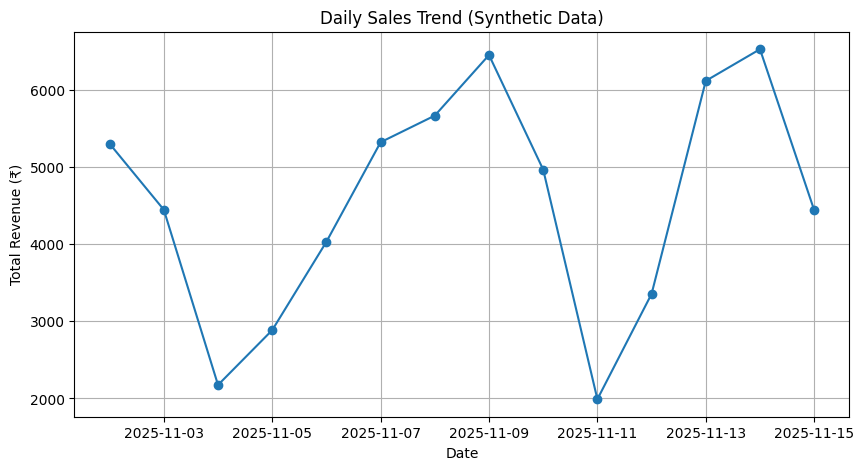

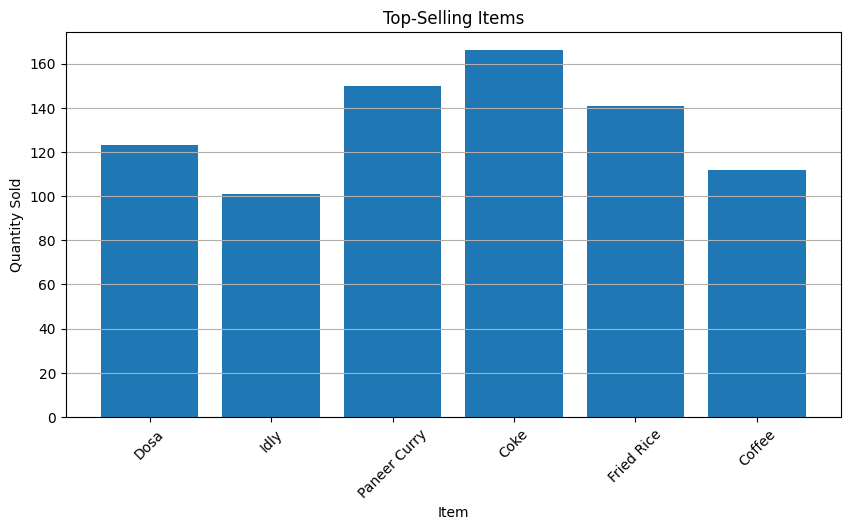

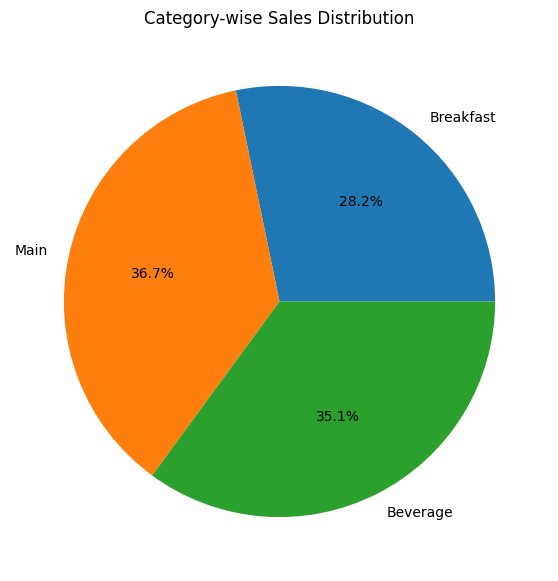

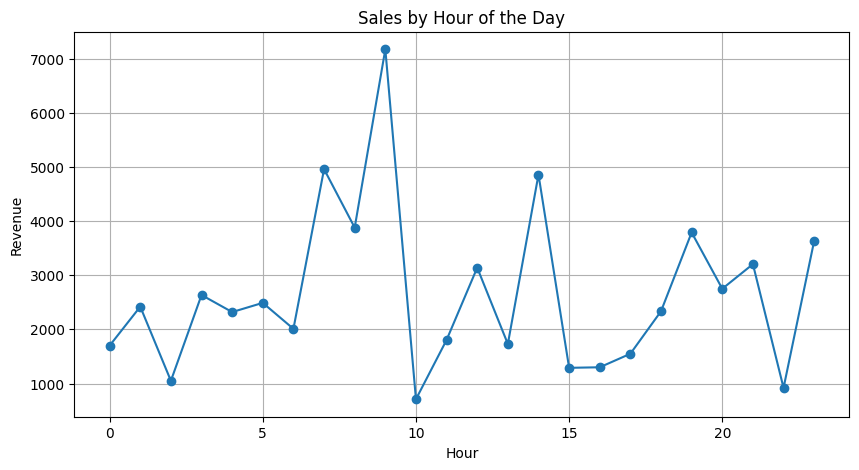

✔ All analytics graphs generated!
👍 You can now take screenshots for the Kaggle Writeup Media Gallery.


In [11]:
# Extended Synthetic Sales & Deep Analytics (Optional Enhancement)
# Generate Synthetic Sales + Rich Analytics Graphs

import random
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

# Load existing data
menu_df = pd.read_csv("data/menu.csv")
sales_df = pd.read_csv("data/sales.csv")

# ---- 1) GENERATE 150 SYNTHETIC ORDERS -------------------------------------

def generate_random_order():
    """Randomly creates a restaurant order"""
    items = []
    for _ in range(random.randint(1, 3)):  # 1–3 items per order
        row = menu_df.sample(1).iloc[0]
        qty = random.randint(1, 4)
        items.append({"name": row["name"], "qty": qty})
    return items

def simulate_sales(num_orders=150):
    rows = []
    base_date = datetime.now() - timedelta(days=15)

    for i in range(num_orders):
        order = generate_random_order()
        total = 0
        for it in order:
            price = float(menu_df[menu_df["name"] == it["name"]]["price"].iloc[0])
            total += price * it["qty"]

        timestamp = base_date + timedelta(minutes=random.randint(10, 20000))

        rows.append({
            "sale_id": str(uuid.uuid4()),
            "timestamp": timestamp.isoformat(),
            "items": json.dumps(order),
            "total": total
        })
    return rows

# Generate and append synthetic data
new_sales = simulate_sales(150)
sales_df = pd.concat([sales_df, pd.DataFrame(new_sales)], ignore_index=True)

# Save back to CSV
sales_df.to_csv("data/sales.csv", index=False)

print("✔ 150 synthetic sales added!")
print("Total rows in sales.csv:", len(sales_df))

# ---- 2) ANALYTICS & BEAUTIFUL GRAPHS ---------------------------------------

# Convert timestamps
sales_df["timestamp"] = pd.to_datetime(sales_df["timestamp"])
sales_df["date"] = sales_df["timestamp"].dt.date

# A) DAILY SALES TREND ---------------------------------------------------------
plt.figure(figsize=(10,5))
daily = sales_df.groupby("date")["total"].sum()
daily.plot(marker="o")
plt.title("Daily Sales Trend (Synthetic Data)")
plt.xlabel("Date")
plt.ylabel("Total Revenue (₹)")
plt.grid(True)
plt.show()

# B) TOP ITEMS BAR CHART -------------------------------------------------------
item_counts = {}

for r in sales_df["items"]:
    for it in json.loads(r):
        item_counts[it["name"]] = item_counts.get(it["name"], 0) + it["qty"]

items = list(item_counts.keys())
counts = list(item_counts.values())

plt.figure(figsize=(10,5))
plt.bar(items, counts)
plt.title("Top-Selling Items")
plt.xlabel("Item")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# C) CATEGORY SHARE PIE CHART --------------------------------------------------
menu_map = menu_df.set_index("name")["category"].to_dict()
category_sum = {}

for item, qty in item_counts.items():
    cat = menu_map.get(item, "Other")
    category_sum[cat] = category_sum.get(cat, 0) + qty

plt.figure(figsize=(7,7))
plt.pie(category_sum.values(), labels=category_sum.keys(), autopct="%1.1f%%")
plt.title("Category-wise Sales Distribution")
plt.show()

# D) HEATMAP (Sales per Hour) --------------------------------------------------
sales_df["hour"] = sales_df["timestamp"].dt.hour
hourly = sales_df.groupby("hour")["total"].sum()

plt.figure(figsize=(10,5))
plt.plot(hourly.index, hourly.values, marker="o")
plt.title("Sales by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

print("✔ All analytics graphs generated!")
